---
# Create mapping and domain files for CESM2 with availble SCRIP files
- Author: Jiang Zhu (jiangzhu@ucar.edu)
- Tools used
  - [pop_tools](https://pop-tools.readthedocs.io/en/latest/)
  - Many scripts / executables from CESM
- Note: one difference from CESM1 (e.g., the [PaleoToolkit](https://github.com/CESM-Development/paleoToolkit)) is the use of Esutary Box Model in POP2.
  As a result, the runoff to ocean mapping is different.
---

In [1]:
import subprocess
import datetime
import copy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import pop_tools

import warnings
warnings.filterwarnings('ignore')

In [2]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

250113


---
## Pre-prepared scripts and executables

In [3]:
paleowg_script_dir = '/glade/campaign/cesm/development/palwg/scripts/setup'

gen_cesm_maps_exe = f"{paleowg_script_dir}/mapping/gen_cesm_maps.sh"
gen_domain_exe = f"{paleowg_script_dir}/gen_domain/gen_domain"

runoff_map_exe = f"{paleowg_script_dir}/runoff_to_ocn/runoff_map"
runoff_merge_mapping_exe = f"{paleowg_script_dir}/runoff_to_ocn/run_merge_mapping_files.sh"

---
## Output files: CESM mapping, domain, and runoff_to_ocean mapping files
- Currently, they will be in the present directory
---

---
## A dictionary for revelant files for each model component

In [4]:
comp_configs = {}

comp_configs['atm'] = {
    'gname': 'fv09',
    'scrip': '/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc',
}

comp_configs['rtm'] = {
    'gname': 'r05_nomask',
    'scrip': '/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/r05_nomask_070925.nc',
    'rdirc': '/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rtmdata/rdirc.05.061026',
}

comp_configs['ocn'] = {
    'gname': 'gx1v7_12ka',
    'scrip': '/glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/gx1v6_12ka_20170803.nc',
    'topo': '/glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/12ka_topography_20170803.ieeei4',
    'rmask': '/glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/12ka_region_mask_20170803.fixed.190520.ieeei4',
    'coast_scrip': f"/glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/gx1v6_12ka_coast_{today}.nc",
}

---
## Step 1: Create scrip file for ocean coast
- This step is needed for CESM2-POP2 to work with the new Estuary Box Model

### Use pop_tools to get grid info and KMT (used as a land-sea mask here)

In [5]:
ds_pop = pop_tools.get_grid('POP_gx1v7')[['KMT']]

ds_pop_coast = ds_pop.copy(deep=True)

nlat, nlon = ds_pop.KMT.shape
print(f"nlat = {nlat}, nlon = {nlon}")

nlat = 384, nlon = 320


### Read paleo kmt from binary file and insert it into `ds_pop`

In [6]:
kmt_data = np.fromfile(comp_configs['ocn']['topo'], dtype='>i4', count=nlat*nlon)
kmt_data = np.reshape(kmt_data, [nlon, nlat], order='F')

ds_pop.KMT.data = kmt_data.T

### Find the grid points for ocean coasts and create a mask
- First, pad kmt in the longitude direction
- Loop over individual ocean grid point and mark it zero if all its neighbors are ocean (i.e. not a costal grid point)
- Insert the coast mask into `ds_pop_coast`

In [7]:
kmt_coast = copy.deepcopy(kmt_data)
kmt_coast = np.where(kmt_coast > 0, 1, 0)
print(f"Original ocean array: {kmt_coast.shape}")

kmt_padded = np.zeros((nlon + 2, nlat))
kmt_padded[1:nlon + 1, :] = kmt_data
kmt_padded[0, :] = kmt_data[nlon - 1, :]
kmt_padded[nlon + 1, :] = kmt_data[0, :]
print(f"Padded ocean array: {kmt_padded.shape}")

Original ocean array: (320, 384)
Padded ocean array: (322, 384)


In [8]:
for i in range(0, nlon):
    for j in range(1, nlat):  # j starts from 1, as kmt_data[:, 0] is always land
        if kmt_coast[i, j] != 0:  # ocean grid points

            # Mark it zero if neighbors are all ocean points (non-zero)
            if (kmt_padded[i, j] != 0 and kmt_padded[i + 2, j] != 0 and
                kmt_padded[i + 1, j - 1] != 0 and kmt_padded[i + 1, j + 1] != 0):
                kmt_coast[i, j] = 0

ds_pop_coast.KMT.data = kmt_coast.T
ds_pop_coast

<xarray.Dataset> Size: 983kB
Dimensions:  (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT      (nlat, nlon) int64 983kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

### Make plot to check the coast mask

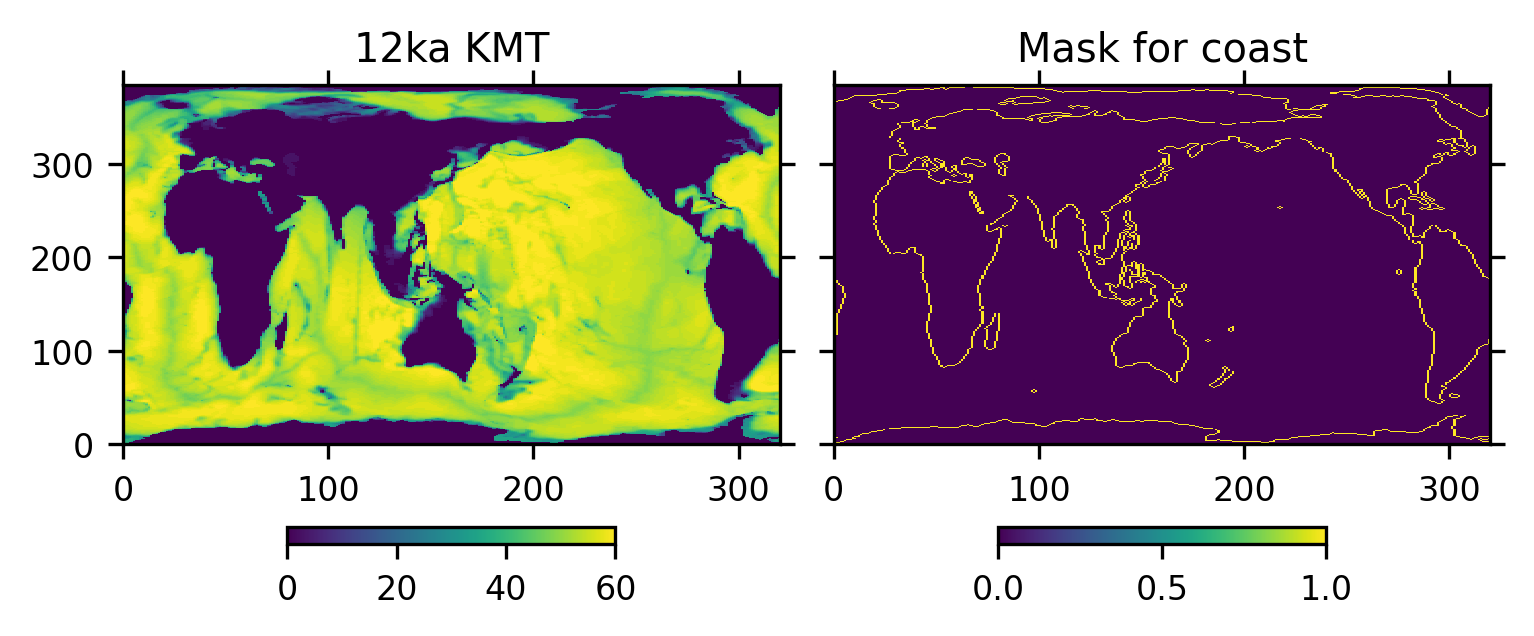

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, ds, title in zip(
    axes.ravel(),
    (ds_pop, ds_pop_coast),
    ('12ka KMT', 'Mask for coast')
):
    hc = ax.pcolormesh(ds.KMT, cmap='viridis')
    ax.set_title(title)
    cb = fig.colorbar(hc, ax=ax, orientation='horizontal', shrink=0.5)

### Save the coast mask (`KMT`) into a new SCRIP file

In [19]:
ds_pop_scrip = xr.open_dataset(comp_configs['ocn']['scrip'])

ds_pop_coast_scrip = ds_pop_scrip.copy(deep=True)
ds_pop_coast_scrip

<xarray.Dataset> Size: 11MB
Dimensions:          (grid_rank: 2, grid_size: 122880, grid_corners: 4)
Dimensions without coordinates: grid_rank, grid_size, grid_corners
Data variables:
    grid_dims        (grid_rank) int32 8B ...
    grid_center_lat  (grid_size) float64 983kB ...
    grid_center_lon  (grid_size) float64 983kB ...
    grid_area        (grid_size) float64 983kB ...
    grid_imask       (grid_size) int32 492kB ...
    grid_corner_lat  (grid_size, grid_corners) float64 4MB ...
    grid_corner_lon  (grid_size, grid_corners) float64 4MB ...
Attributes:
    title:             12ka
    Created_by:        pdinezio, Thu Aug  3 10:28:31 MDT 2017
    1D_grid_indexing:  if n is 1D index, i runs fast, j runs slow: n=(j-1)*fa...

In [11]:
ds_pop_coast_scrip.grid_imask.data = ds_pop_coast.KMT.values.flatten()

del ds_pop_coast_scrip.attrs['Created_by']
del ds_pop_coast_scrip.attrs['title']

ds_pop_coast_scrip.attrs['Title'] = 'SCRIP file for POP coast at 12 ka'
ds_pop_coast_scrip.attrs['Author'] = 'Jiang Zhu (jiangzhu@ucar.edu)'
ds_pop_coast_scrip.attrs['Source_file'] = comp_configs['ocn']['scrip']
ds_pop_coast_scrip.attrs['Script'] = 'create_mapping_cesm2.ipynb'
ds_pop_coast_scrip.attrs['More_info'] = 'https://github.com/NCAR/paleowg-recipes/cesm2'
ds_pop_coast_scrip.attrs["Date_created"] = datetime.datetime.now().isoformat()

ds_pop_coast_scrip.to_netcdf(
    comp_configs['ocn']['coast_scrip'], format="NETCDF3_64BIT")

ds_pop_coast_scrip

<xarray.Dataset> Size: 12MB
Dimensions:          (grid_rank: 2, grid_size: 122880, grid_corners: 4)
Dimensions without coordinates: grid_rank, grid_size, grid_corners
Data variables:
    grid_dims        (grid_rank) int32 8B ...
    grid_center_lat  (grid_size) float64 983kB ...
    grid_center_lon  (grid_size) float64 983kB ...
    grid_area        (grid_size) float64 983kB ...
    grid_imask       (grid_size) int64 983kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    grid_corner_lat  (grid_size, grid_corners) float64 4MB ...
    grid_corner_lon  (grid_size, grid_corners) float64 4MB ...
Attributes:
    1D_grid_indexing:  if n is 1D index, i runs fast, j runs slow: n=(j-1)*fa...
    Title:             SCRIP file for POP coast at 12 ka
    Author:            Jiang Zhu (jiangzhu@ucar.edu)
    Source_file:       /glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12...
    Script:            create_mapping_cesm2.ipynb
    More_info:         https://github.com/NCAR/paleowg-recipes/cesm2
    Date_created:      2025-01-13T22:13:13.258379

## Step 2: Create mapping and domain files
- Use `subprocess` to run `gen_cesm_maps_exe` and `gen_domain_exe`
- Make sure you load modules that work on Casper
- NOTE and KEEP the `space` in the f-string!

### cesm mapping files

In [13]:
%%time

cmd = (
    f"module load ncarenv/24.12 intel/2024.2.1 mpi-serial/2.5.0 esmf/8.7.0; "
    f"{gen_cesm_maps_exe} --nogridcheck "
    f"-natm {comp_configs['atm']['gname']} -fatm {comp_configs['atm']['scrip']} "
    f"-nocn {comp_configs['ocn']['gname']} -focn {comp_configs['ocn']['scrip']} "
    f"-nrtm {comp_configs['rtm']['gname']} -frtm {comp_configs['rtm']['scrip']} "
)

subprocess.run(cmd, shell=True)


Due to MODULEPATH changes, the following have been reloaded:
  1) conda/latest

The following have been reloaded with a version change:
  1) ncarenv/23.10 => ncarenv/24.12



/glade/campaign/cesm/development/palwg/scripts/setup/mapping/gen_cesm_maps.sh
Mon 13 Jan 2025 10:13:13 PM MST
Will not check quality of maps!
Assuming atmosphere and land grid are identical, generating atm2rof and rof2atm maps
/glade/campaign/cesm/development/palwg/scripts/setup/mapping/create_ESMF_map.sh
Mon 13 Jan 2025 10:13:14 PM MST
type_src is global
type_dst is global
map_type is aave
fsrc is /glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/gx1v6_12ka_20170803.nc
fdst is /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc

Creating map_gx1v7_12ka_TO_fv09_aave.250113.nc...
cmd is  ESMF_RegridWeightGen --ignore_unmapped --ignore_degenerate -m conserve -w map_gx1v7_12ka_TO_fv09_aave.250113.nc -s /glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/gx1v6_12ka_20170803.nc -d /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc 

 Starting weight generation with these inputs: 
   Source File: 
 /glade/work/jiangzhu/data/inp

CompletedProcess(args='module load ncarenv/24.12 intel/2024.2.1 mpi-serial/2.5.0 esmf/8.7.0; /glade/campaign/cesm/development/palwg/scripts/setup/mapping/gen_cesm_maps.sh --nogridcheck -natm fv09 -fatm /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc -nocn gx1v7_12ka -focn /glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/gx1v6_12ka_20170803.nc -nrtm r05_nomask -frtm /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/r05_nomask_070925.nc ', returncode=0)

### Generate domain file

In [14]:
cmd = (
    f"{gen_domain_exe} -p 2 -c 12ka "
    f"-m map_{comp_configs['ocn']['gname']}_TO_{comp_configs['atm']['gname']}_aave.{today}.nc "
    f"-o {comp_configs['ocn']['gname']} -l {comp_configs['atm']['gname']} "
)

subprocess.run(cmd, shell=True)

 set_fv_pole_yc is            2
 fmap   = map_gx1v7_12ka_TO_fv09_aave.250113.nc
 fn1_out_ocn= domain.ocn.gx1v7_12ka.250113.nc
 fn2_out_lnd= domain.lnd.fv09_gx1v7_12ka.250113.nc
 fn2_out_ocn= domain.ocn.fv09_gx1v7_12ka.250113.nc
 usercomment= 12ka
 eps    =   9.999999960041972E-013
 fminval=   1.000000000000000E-003
 fmaxval=    1.00000000000000     
 set_fv_pole_yc =            2
  
 input SCRIP data...
 pole_fix =  F
  
 input file  = map_gx1v7_12ka_TO_fv09_aave.250113.nc
 open map_gx1v7_12ka_TO_fv09_aave.250113.nc
 domain_a     = 
 /glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/gx1v6_12ka_20170803.nc
 domain_b     = 
 /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc
 grid_file_ocn= 
 /glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/gx1v6_12ka_20170803.nc
 grid_file_atm= 
 /glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc
 n,nv,ni,nj,na,ns=       122880           4      122880           1      122880
      2419

CompletedProcess(args='/glade/campaign/cesm/development/palwg/scripts/setup/gen_domain/gen_domain -p 2 -c 12ka -m map_gx1v7_12ka_TO_fv09_aave.250113.nc -o gx1v7_12ka -l fv09 ', returncode=0)

## Step 3 (**DIFFERENT FROM CESM1**): Create rof to ocean mapping file

### Create a namelist file

In [15]:
ocn_dict = comp_configs['ocn']
fname_nn = f"map_r05_to_{ocn_dict['gname']}_coast_nn_{today}.nc"
fname_sm = f"map_{ocn_dict['gname']}_coast_to_{ocn_dict['gname']}_sm_{today}.nc"
fname_new = f"map_r05_to_{ocn_dict['gname']}_nnsm_e1000r300_{today}.nc"
fname_merged = f"map_r05_to_{ocn_dict['gname']}_merged_{today}.nc"

runoff_map_nml = f"r05_to_{ocn_dict['gname']}_nnsm_e1000r3000.nml"
with open(runoff_map_nml, "w") as f:
    f.write(f"&input_nml\n")
    f.write(f"gridtype = 'rtm'\n")
    f.write(f"file_roff = '{comp_configs['rtm']['rdirc']}'\n")
    f.write(f"file_ocn = '{ocn_dict['scrip']}'\n")
    f.write(f"file_ocn_coastal_mask = '{ocn_dict['coast_scrip']}'\n")
    f.write(f"file_nn = '{fname_nn}'\n")
    f.write(f"file_smooth = '{fname_sm}'\n")
    f.write(f"file_new = '{fname_new}'\n")
    f.write(f"title = 'runoff map: r05 -> {ocn_dict['gname']}, nearest neighbor and smoothed'\n")
    f.write(f"eFold = 1000000.0\n")
    f.write(f"rMax = 300000.0\n")
    f.write(f"restrict_smooth_src_to_nn_dest = .true.\n")
    f.write(f"step1 = .true.\n")
    f.write(f"step2 = .true.\n")
    f.write(f"step3 = .true.\n")
    f.write(f"/\n")

### Run runoff_map

In [16]:
%%time

cmd = (f"{runoff_map_exe} < {runoff_map_nml}")
print(cmd)

subprocess.run(cmd, shell=True)

/glade/campaign/cesm/development/palwg/scripts/setup/runoff_to_ocn/runoff_map < r05_to_gx1v7_12ka_nnsm_e1000r3000.nml
(main) -------------------------------------------------------------------------
(main) correct/smooth/sort runoff -> ocean map
(main) -------------------------------------------------------------------------
(main) -------------------------------------------------------------------------
(main) Step 0:  read input namelist data
(main) -------------------------------------------------------------------------
(main) Namelist values...
(main)    gridtype                       = rtm
(main)    file_roff                      = /glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/rtmdata/rdirc.05.061026
(main)    file_ocn (global)              = /glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/gx1v6_12ka_20170803.nc
(main)    file_ocn (coast)               = /glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/gx1v6_12ka_coast_250113.nc
(main)    file_nn              

CompletedProcess(args='/glade/campaign/cesm/development/palwg/scripts/setup/runoff_to_ocn/runoff_map < r05_to_gx1v7_12ka_nnsm_e1000r3000.nml', returncode=0)

### Run merge map ncl script

In [17]:
cmd = (
    f"{runoff_merge_mapping_exe} --region_mask {comp_configs['ocn']['rmask']} "
    f"--map_in_oo {fname_nn} "
    f"--map_in_ms {fname_new} "
    f"--map_out {fname_merged} "
)
subprocess.run(cmd, shell=True)

 Copyright (C) 1995-2019 - All Rights Reserved
 University Corporation for Atmospheric Research
 NCAR Command Language Version 6.6.2
 The use of this software is governed by a License Agreement.
 See http://www.ncl.ucar.edu/ for more details.
(0)	comparing grid vars in
(0)	  MAP_IN_OO_FNAME = map_r05_to_gx1v7_12ka_coast_nn_250113.nc
(0)	  MAP_IN_MS_FNAME = map_r05_to_gx1v7_12ka_nnsm_e1000r300_250113.nc
(0)	  xc_a values agree
(0)	  yc_a values agree
(0)	  mask_a values agree
(0)	  area_a values agree
(0)	  frac_a values agree
(0)	  src_grid_dims values agree
(0)	  xc_b values agree
(0)	  yc_b values agree
(0)	  area_b values agree
(0)	  dst_grid_dims values agree
(0)	grid variables are compatible
(0)	reading grid info and map from map_r05_to_gx1v7_12ka_coast_nn_250113.nc
(0)	reading map from map_r05_to_gx1v7_12ka_nnsm_e1000r300_250113.nc
(0)	checking col value compatibility
(0)	reading REGION_MASK
(0)	determining map_oo vals where REGION_MASK>0
(0)	determining map_ms vals where REGION_

CompletedProcess(args='/glade/campaign/cesm/development/palwg/scripts/setup/runoff_to_ocn/run_merge_mapping_files.sh --region_mask /glade/work/jiangzhu/data/inputdata/cesm120ka_ICEG6/12ka/12ka_region_mask_20170803.fixed.190520.ieeei4 --map_in_oo map_r05_to_gx1v7_12ka_coast_nn_250113.nc --map_in_ms map_r05_to_gx1v7_12ka_nnsm_e1000r300_250113.nc --map_out map_r05_to_gx1v7_12ka_merged_250113.nc ', returncode=0)